In [9]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

from DataFields import DateReportedFields
from ProjectFunctions import *

#### Check frequency for education on diagnosed and undiagnosed

In [10]:
iterations = 8
for i in range(1, iterations + 1):
    df_diagnosed = pd.read_csv("diagnosed.csv") # without any post processing
    df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{i}_{i}.csv") # without post processing
    
    df_merged = pd.concat([df_diagnosed, df_undiagnosed], ignore_index=True, sort=False)
    
    df_merged = one_hot_encode_vascular_problems(df_merged)
    df_merged = map_education_levels(df_merged)
    
    #df_merged = df_merged.drop(columns=columns_to_drop) # columns to exclude, if wanted 
    
    df_merged = convert_date_to_binary(df_merged, DateReportedFields)
    
    percentages = df_merged.groupby('Vascular Dementia Report Date')['Education']\
                    .value_counts(normalize=True)\
                    .unstack(fill_value=0) * 100
    print()
    print(f"Iteration: {i}")
    print(percentages)


Iteration: 1
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              32.025819  21.201589  22.889772  23.882820
1                              39.059501  20.585413  23.032630  17.322457

Iteration: 2
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              29.940269  22.697860  23.220508  24.141364
1                              39.059501  20.585413  23.032630  17.322457

Iteration: 3
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              29.893298  22.340780  22.374125  25.391797
1                              39.059501  20.585413  23.032630  17.322457

Iteration: 4
Education                            0.0        1.0     

/tmp/ipykernel_883065/2092949634.py:4: DtypeWarning: Columns (16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{i}_{i}.csv") # without post processing



Iteration: 5
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              30.562762  22.201157  22.460587  24.775494
1                              39.059501  20.585413  23.032630  17.322457

Iteration: 6
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              30.979935  21.813338  22.221297  24.985430
1                              39.059501  20.585413  23.032630  17.322457


/tmp/ipykernel_883065/2092949634.py:4: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{i}_{i}.csv") # without post processing



Iteration: 7
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              30.178444  21.763026  22.740899  25.317630
1                              39.059501  20.585413  23.032630  17.322457

Iteration: 8
Education                            0.0        1.0        2.0        3.0
Vascular Dementia Report Date                                            
0                              30.378578  21.698984  22.181973  25.740465
1                              39.059501  20.585413  23.032630  17.322457


#### Create Dataset

In [11]:
def create_dataset(index = 1, columns_to_drop = []):
    df_diagnosed = pd.read_csv("diagnosed.csv")
    df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{index}_{index}.csv")
    
    df_merged = pd.concat([df_diagnosed, df_undiagnosed], ignore_index=True, sort=False)

    df_merged = one_hot_encode_vascular_problems(df_merged)
    df_merged = map_education_levels(df_merged)

    df_merged = df_merged.drop(columns=columns_to_drop) # columns to exclude, if wanted 
    
    df_merged = convert_date_to_binary(df_merged, DateReportedFields)
    
    df_merged = drop_correlated_features(df_merged, threshold = 0.8, keep_list=["Vascular Dementia Report Date", "Sex"])

    df_merged = drop_rows_with_na_greater_than(df_merged, 45)
    
    # split to test and train
    X = df_merged.drop('Vascular Dementia Report Date', axis=1)  # Features
    y = df_merged['Vascular Dementia Report Date']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test
    

#### Create XGB Classifier

In [12]:
def train_dataset(X_train, X_test, y_train, y_test):
    xgb_model = xgb.XGBClassifier(eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    return xgb_model, y_pred, y_prob

#### Plot ROC Curve

In [13]:
def plot_ROC(y_test, y_prob, index = 1):
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve for dataset_{index}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"dataset_output/roc_curve_dataset_{index}.png")
    plt.show()

#### Plot Confusion Matrix

In [14]:
def plot_confusion(y_test, y_pred, index = 1):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for dataset_{index}')
    plt.tight_layout()
    plt.savefig(f"dataset_output/confusion_matrix_dataset_{index}.png")
    plt.show()

#### SHAP Explainer

In [15]:
def plot_explainer(xgb_model, X_train, X_test, index = 1):
    explainer = shap.Explainer(xgb_model, X_train, feature_names=X_train.columns)
    shap_values = explainer(X_test)
    
    shap.summary_plot(shap_values, X_test, show = False)
    plt.savefig(f"dataset_output/shap_summary_dataset_{index}.png", bbox_inches="tight")

### Run multiple iterations


Iteration 1
Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
Monocyte percentage
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
White blood cell (leukocyte) count
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Testosterone
Accuracy: 0.7488038277511961
ROC AUC Score: 0.8276106802506941


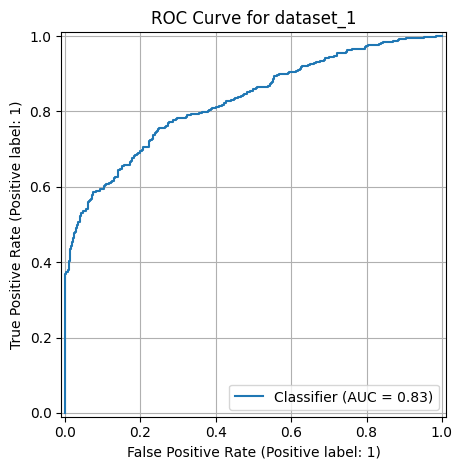

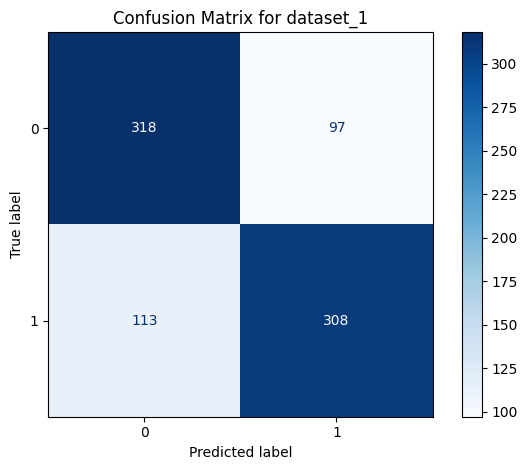


Iteration 2
Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.7689210950080515
ROC AUC Score: 0.7757032499940302


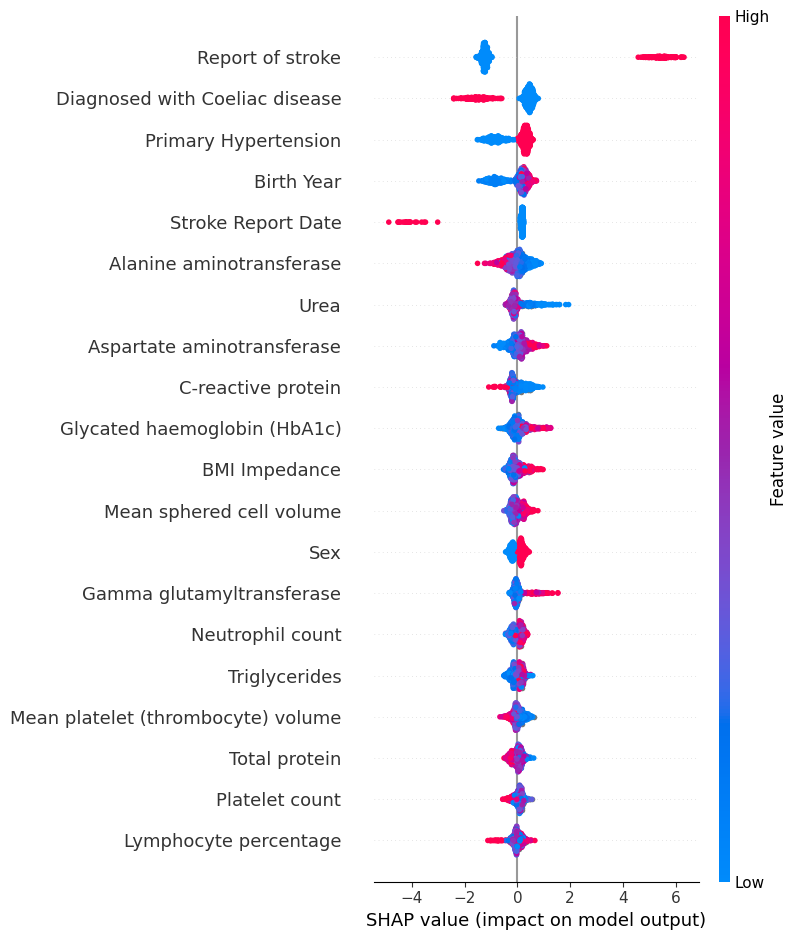

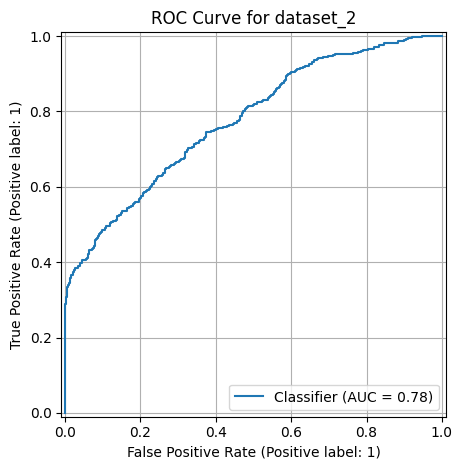

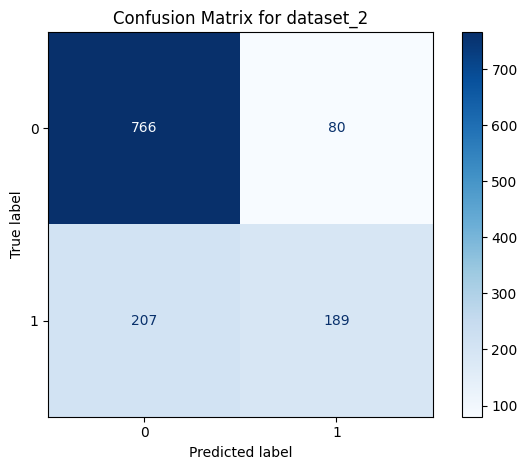


Iteration 3
Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
White blood cell (leukocyte) count
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.8121212121212121
ROC AUC Score: 0.7897767420306728


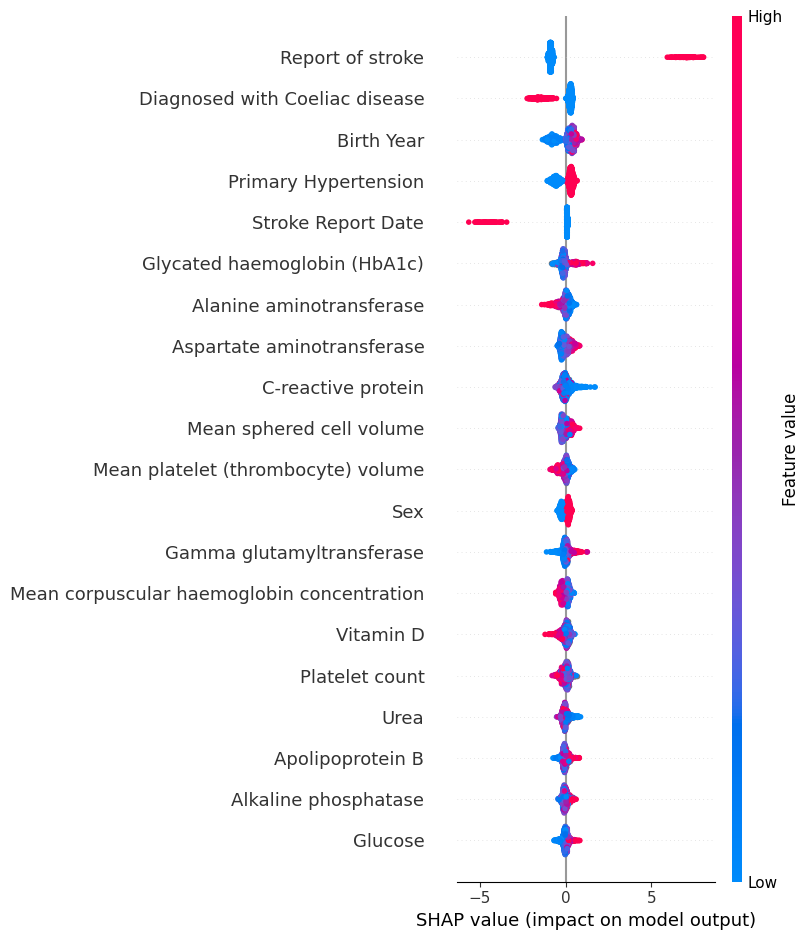

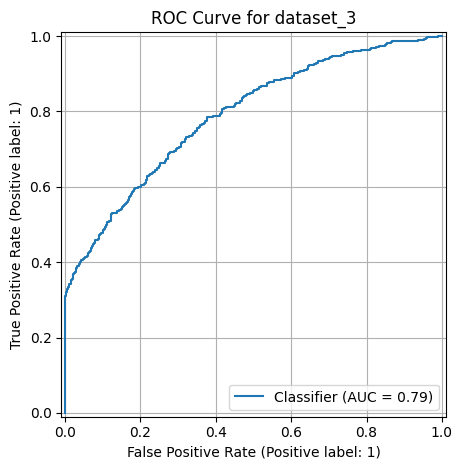

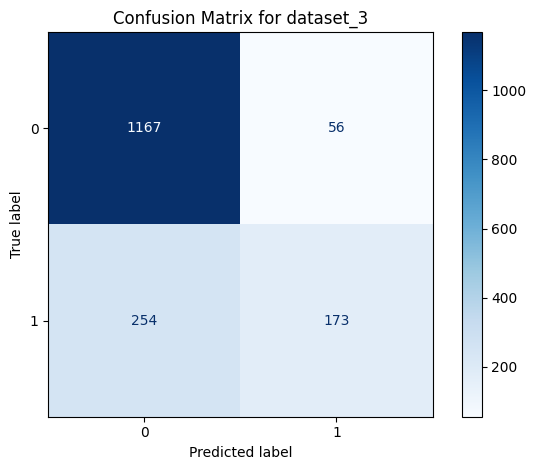


Iteration 4
Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
White blood cell (leukocyte) count
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.8468643655809431
ROC AUC Score: 0.7844902110348335


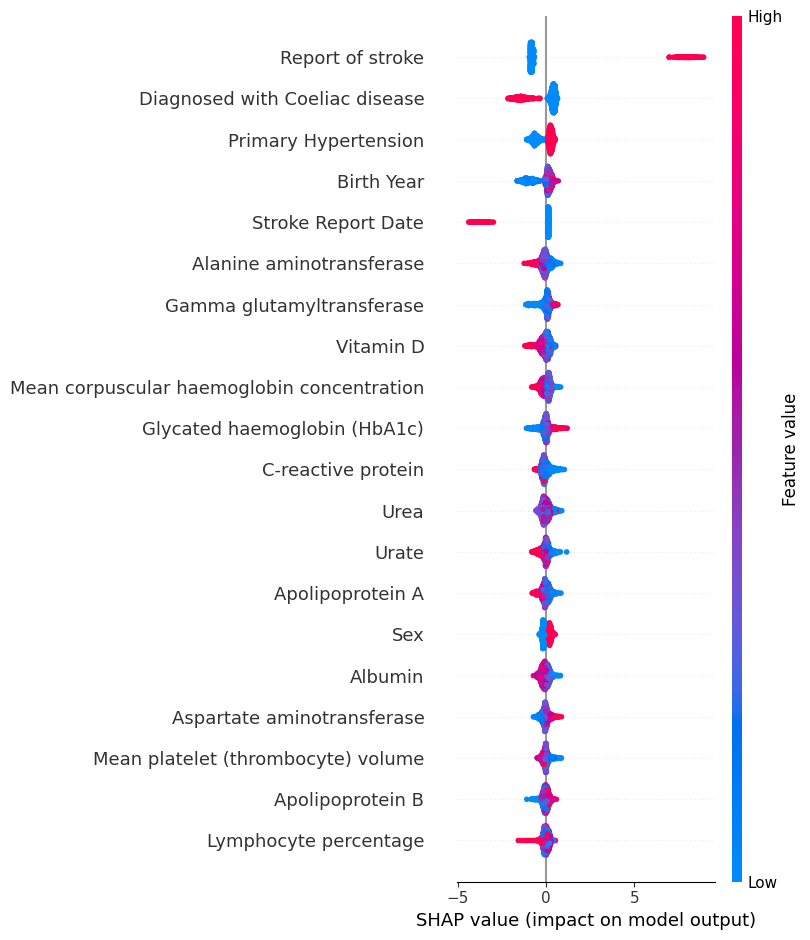

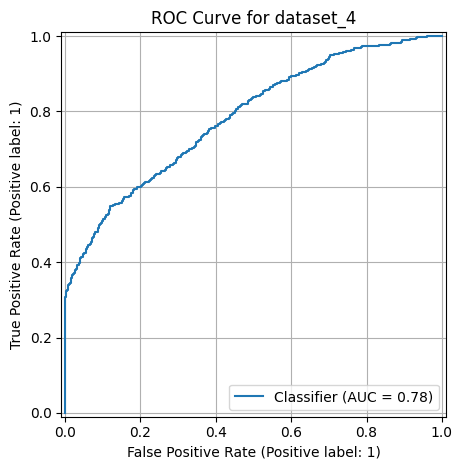

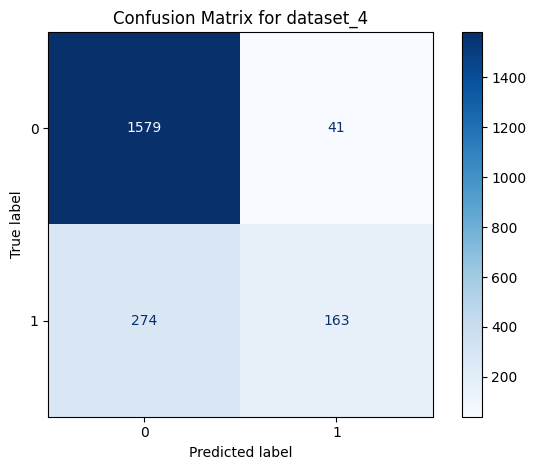


Iteration 5


/tmp/ipykernel_883065/294946736.py:3: DtypeWarning: Columns (16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{index}_{index}.csv")


Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.8823051948051948
ROC AUC Score: 0.8190278912685524


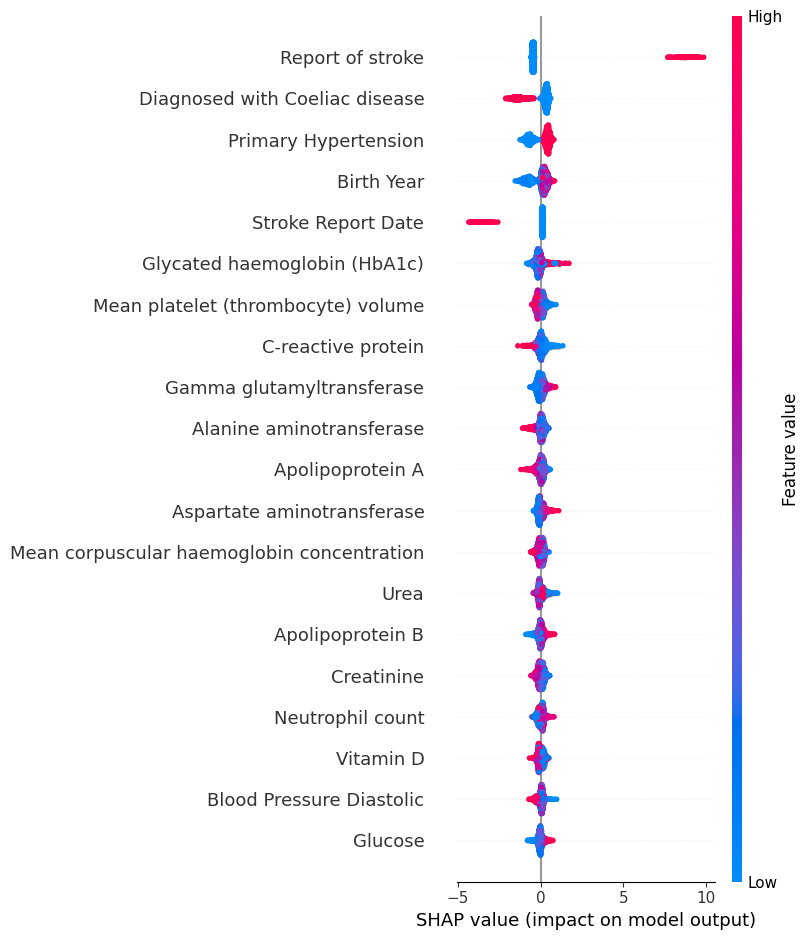

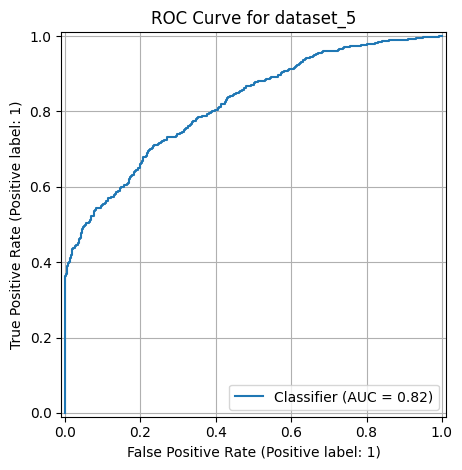

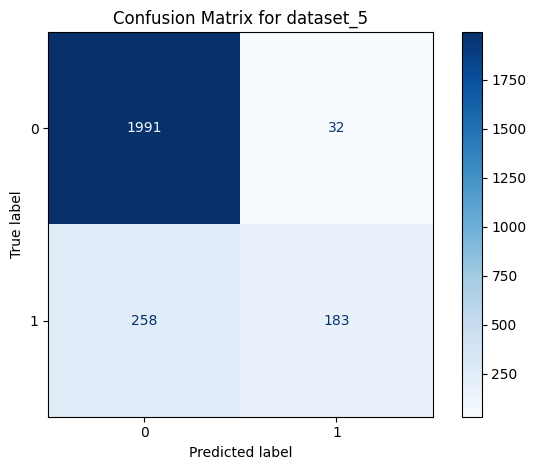

 98%|===================| 2415/2464 [00:13<00:00]        


Iteration 6
Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
White blood cell (leukocyte) count
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.8892757660167131
ROC AUC Score: 0.7910141045613841


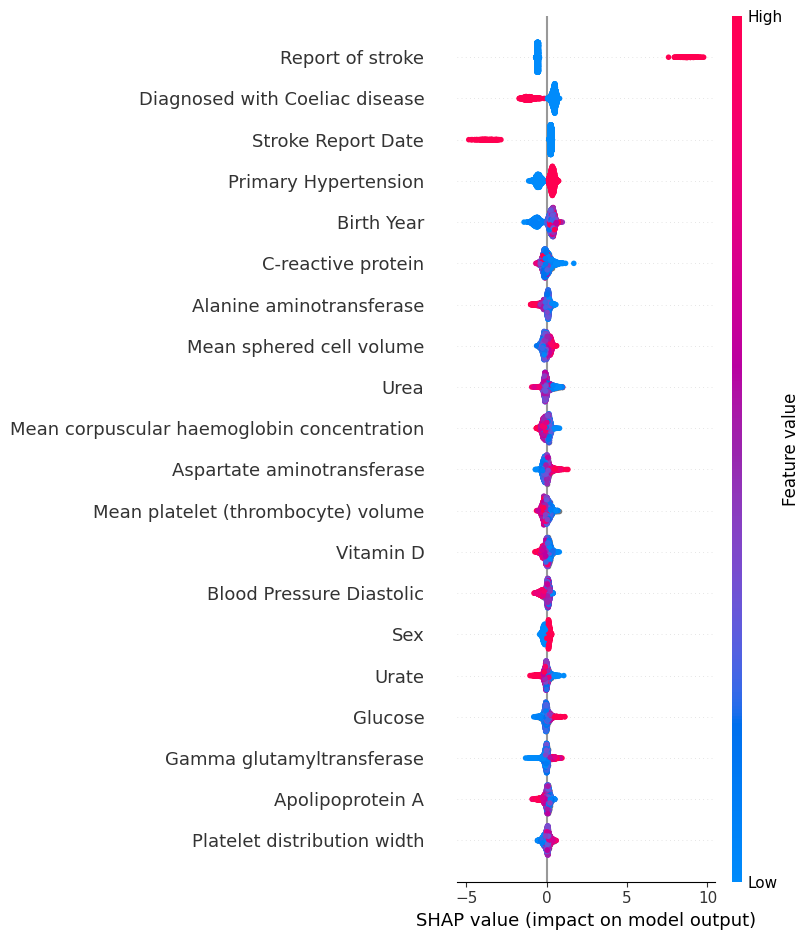

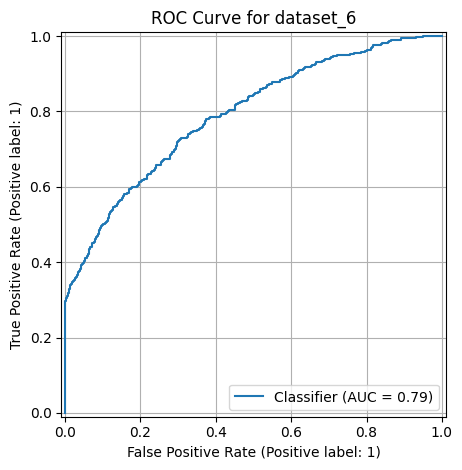

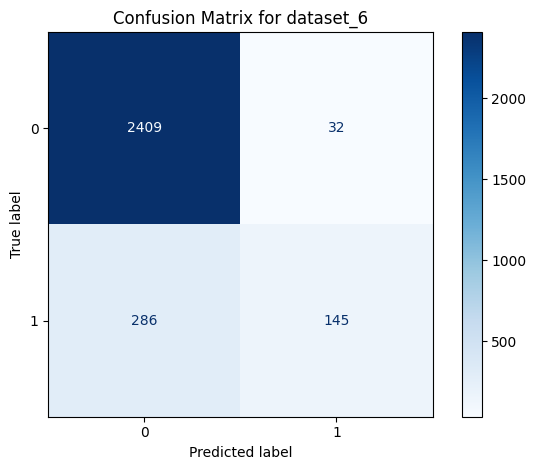

100%|===================| 2858/2872 [00:14<00:00]        


Iteration 7


/tmp/ipykernel_883065/294946736.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{index}_{index}.csv")


Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
White blood cell (leukocyte) count
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.9054589813967673
ROC AUC Score: 0.7720388224897934


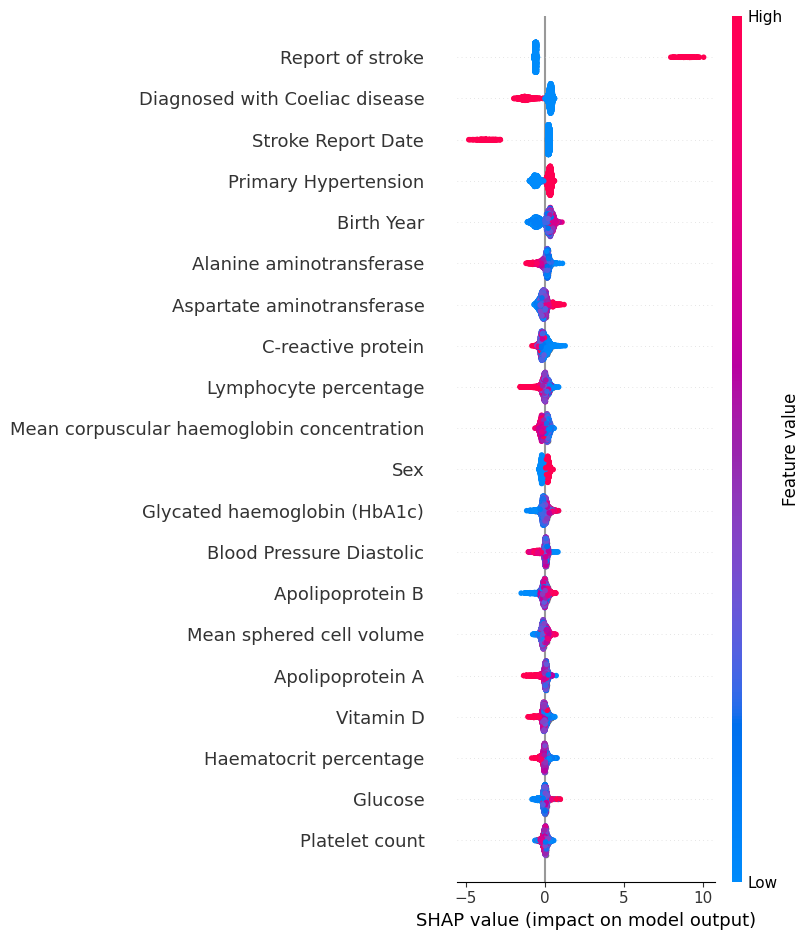

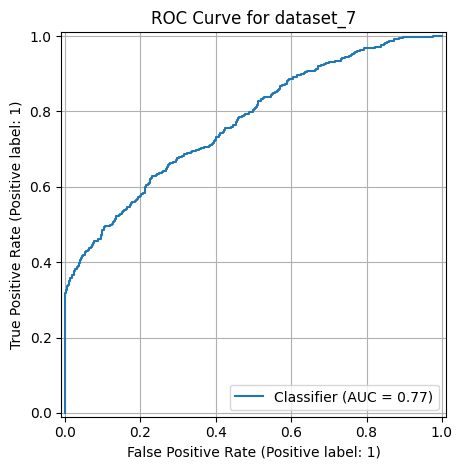

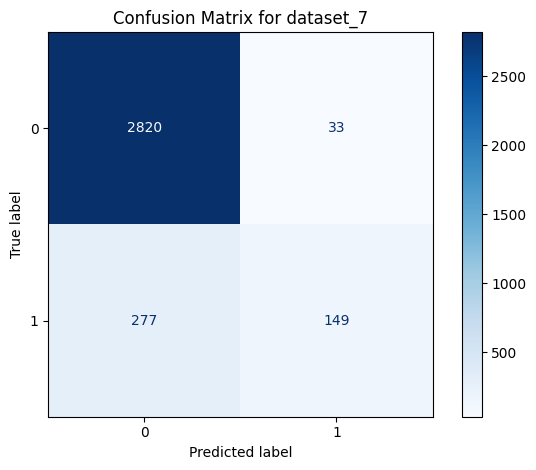

 97%|=================== | 3186/3279 [00:16<00:00]       


Iteration 8
Features dropped:
Total bilirubin
Cholesterol
HDL cholesterol
High light scatter reticulocyte percentage
Neutrophil percentage
Platelet crit
LDL direct
Eosinophil percentage
Red blood cell (erythrocyte) count
Reticulocyte percentage
Haemoglobin concentration
Basophil percentage
Nucleated red blood cell percentage
Mean corpuscular volume
Testosterone
Accuracy: 0.9133475220431743
ROC AUC Score: 0.8222376329172445


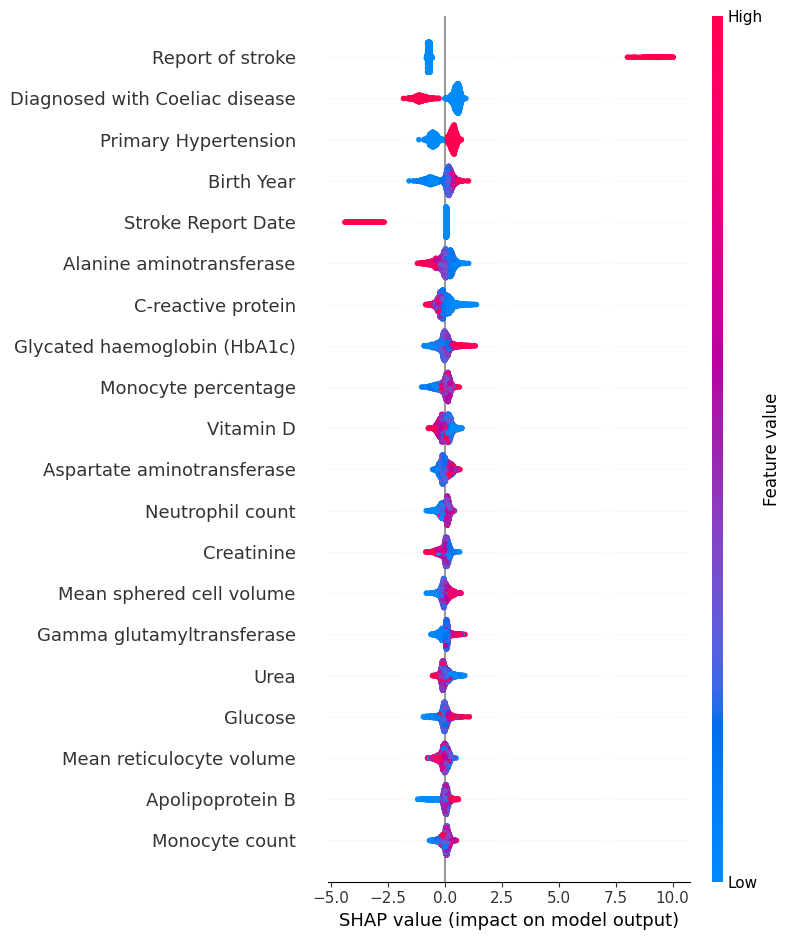

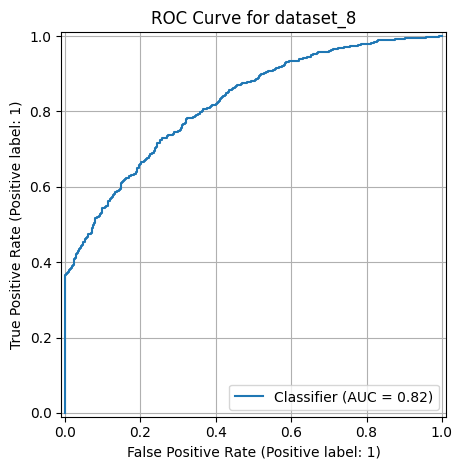

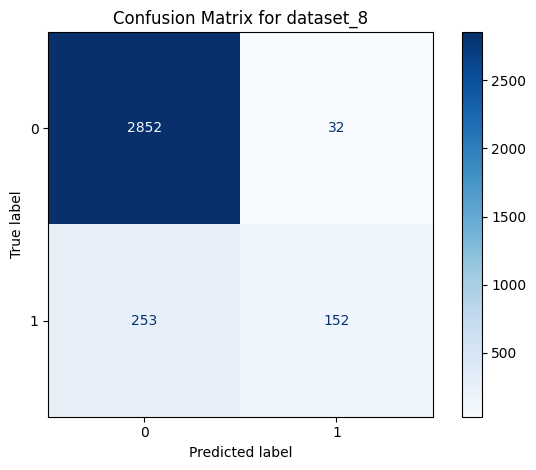

 94%|=================== | 3103/3289 [00:16<00:00]       

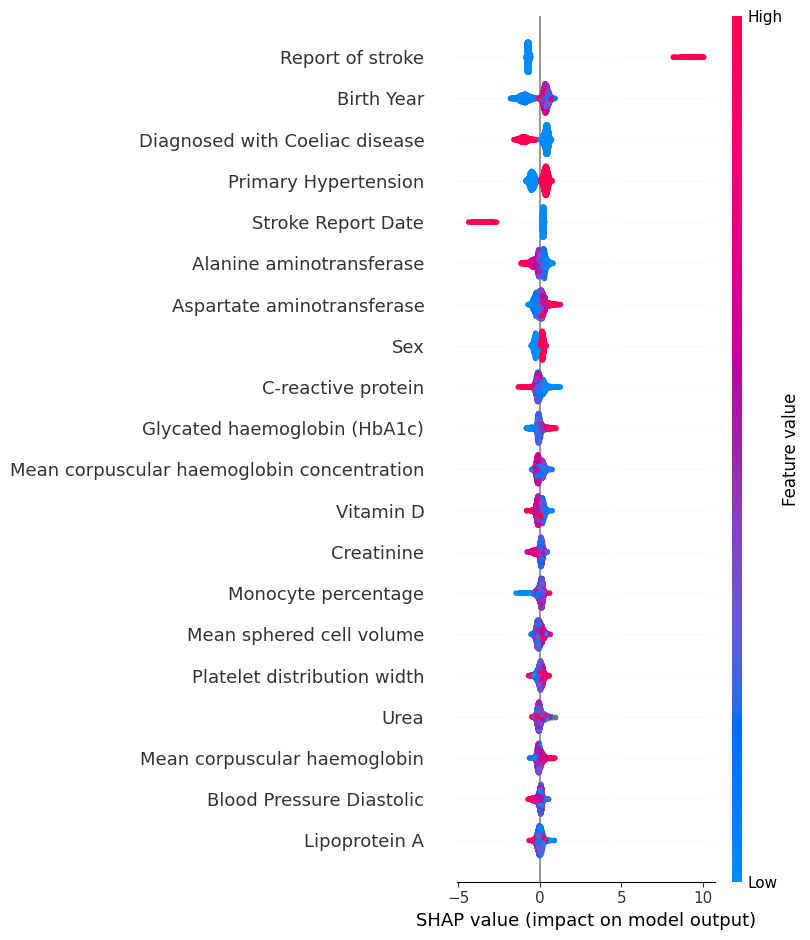

In [16]:
iterations = 8

for idx in range(1, iterations + 1):
    print()
    print(f"Iteration {idx}")
    
    X_train, X_test, y_train, y_test = create_dataset(idx, columns_to_drop=["id"])
    
    xgb_model, y_pred, y_prob = train_dataset(X_train, X_test, y_train, y_test)
    
    plot_ROC(y_test, y_prob, idx)
    
    plot_confusion(y_test, y_pred, idx)
    
    plot_explainer(xgb_model, X_train, X_test, idx)
    